In [1]:
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt

from rdkit import Chem
from mordred import Calculator, descriptors
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error

c:\Users\sbjan\miniconda3\envs\scikit_test\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("data/train.csv")[['Canonical_Smiles', 'Inhibition']]

In [3]:
df['mol'] = df['Canonical_Smiles'].apply(Chem.MolFromSmiles)
df = df[df['mol'].notnull()].reset_index(drop=True)

In [4]:
calc = Calculator(descriptors, ignore_3D=True)
desc = calc.pandas(df['mol'])

 33%|███▎      | 556/1681 [00:04<00:07, 157.95it/s]

c:\Users\sbjan\miniconda3\envs\scikit_test\lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 78%|███████▊  | 1316/1681 [00:09<00:01, 188.88it/s]

c:\Users\sbjan\miniconda3\envs\scikit_test\lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████| 1681/1681 [00:12<00:00, 129.54it/s]


In [5]:
# 1. 숫자형 컬럼만 추출
desc_numeric = desc.select_dtypes(include=[np.number])

# 2. 전부 NaN인 열 제거
desc_numeric = desc_numeric.dropna(axis=1, how='all')

# 3. 중앙값으로 NaN 처리
imputer = SimpleImputer(strategy='median')
desc_imputed_array = imputer.fit_transform(desc_numeric)

# 4. DataFrame으로 복원
desc_imputed = pd.DataFrame(desc_imputed_array, columns=desc_numeric.columns)

# 5. 이상치 클리핑
desc_imputed = desc_imputed.clip(upper=1e6)

# 6. X, y 준비
X = desc_imputed
y = df['Inhibition'].values


In [6]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [7]:
def tune_ridge(trial):
    alpha = trial.suggest_float("alpha", 1e-3, 10.0, log=True)
    model = make_pipeline(StandardScaler(), Ridge(alpha=alpha))
    score = cross_val_score(model, X, y, cv=cv, scoring='neg_root_mean_squared_error').mean()
    return -score

def tune_lasso(trial):
    alpha = trial.suggest_float("alpha", 1e-3, 10.0, log=True)
    model = make_pipeline(StandardScaler(), Lasso(alpha=alpha, max_iter=10000))
    score = cross_val_score(model, X, y, cv=cv, scoring='neg_root_mean_squared_error').mean()
    return -score

def tune_elasticnet(trial):
    alpha = trial.suggest_float("alpha", 1e-3, 10.0, log=True)
    l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)
    model = make_pipeline(StandardScaler(), ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=10000))
    score = cross_val_score(model, X, y, cv=cv, scoring='neg_root_mean_squared_error').mean()
    return -score

def tune_svr(trial):
    C = trial.suggest_float("C", 1e-2, 100.0, log=True)
    epsilon = trial.suggest_float("epsilon", 1e-3, 1.0, log=True)
    kernel = trial.suggest_categorical("kernel", ["rbf", "linear"])
    gamma = trial.suggest_categorical("gamma", ["scale", "auto"])
    model = make_pipeline(StandardScaler(), SVR(C=C, epsilon=epsilon, kernel=kernel, gamma=gamma))
    score = cross_val_score(model, X, y, cv=cv, scoring='neg_root_mean_squared_error').mean()
    return -score

def tune_rf(trial):
    model = RandomForestRegressor(
        n_estimators=trial.suggest_int("n_estimators", 50, 200),
        max_depth=trial.suggest_int("max_depth", 3, 20),
        min_samples_split=trial.suggest_int("min_samples_split", 2, 10),
        min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 5),
        max_features=trial.suggest_categorical("max_features", ["sqrt", "log2"]),
        random_state=42,
        n_jobs=-1
    )
    score = cross_val_score(model, X, y, cv=cv, scoring='neg_root_mean_squared_error').mean()
    return -score

def tune_gbr(trial):
    model = GradientBoostingRegressor(
        n_estimators=trial.suggest_int("n_estimators", 50, 200),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.3),
        max_depth=trial.suggest_int("max_depth", 3, 10),
        subsample=trial.suggest_float("subsample", 0.6, 1.0),
        random_state=42
    )
    score = cross_val_score(model, X, y, cv=cv, scoring='neg_root_mean_squared_error').mean()
    return -score

def tune_histgbr(trial):
    model = HistGradientBoostingRegressor(
        max_iter=trial.suggest_int("max_iter", 50, 200),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.3),
        max_leaf_nodes=trial.suggest_int("max_leaf_nodes", 10, 100),
        min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 20),
        l2_regularization=trial.suggest_float("l2_regularization", 0.0, 1.0),
        random_state=42
    )
    score = cross_val_score(model, X, y, cv=cv, scoring='neg_root_mean_squared_error').mean()
    return -score

In [8]:
study_results = {}
models = {
    "Ridge": tune_ridge,
    "Lasso": tune_lasso,
    "ElasticNet": tune_elasticnet,
    "SVR": tune_svr,
    "RandomForest": tune_rf,
    "GradientBoosting": tune_gbr,
    "HistGradientBoosting": tune_histgbr
}

for name, objective in models.items():
    print(f"Starting tuning for {name}...")
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=50) 
    study_results[name] = {
        "best_score": study.best_value,
        "best_params": study.best_params
    }
    print(f"{name} done. Best RMSE: {study.best_value:.4f}")


[I 2025-07-02 20:50:26,373] A new study created in memory with name: no-name-baefbef5-72e2-40ff-8b9f-1b0f902de2bd


Starting tuning for Ridge...


[I 2025-07-02 20:50:26,801] Trial 0 finished with value: 74.55680384318372 and parameters: {'alpha': 0.0013122093042583797}. Best is trial 0 with value: 74.55680384318372.
[I 2025-07-02 20:50:27,215] Trial 1 finished with value: 58.72197022315297 and parameters: {'alpha': 0.008546050552982675}. Best is trial 1 with value: 58.72197022315297.
[I 2025-07-02 20:50:27,626] Trial 2 finished with value: 32.997808179422776 and parameters: {'alpha': 0.3180468202790417}. Best is trial 2 with value: 32.997808179422776.
[I 2025-07-02 20:50:28,073] Trial 3 finished with value: 53.472666871248485 and parameters: {'alpha': 0.01456258229597984}. Best is trial 2 with value: 32.997808179422776.
[I 2025-07-02 20:50:28,526] Trial 4 finished with value: 29.5361115397075 and parameters: {'alpha': 0.8563048445709946}. Best is trial 4 with value: 29.5361115397075.
[I 2025-07-02 20:50:28,952] Trial 5 finished with value: 46.12170947923299 and parameters: {'alpha': 0.03337265266781515}. Best is trial 4 with val

Ridge done. Best RMSE: 25.4205
Starting tuning for Lasso...


c:\Users\sbjan\miniconda3\envs\scikit_test\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.094e+04, tolerance: 9.370e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\sbjan\miniconda3\envs\scikit_test\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.796e+03, tolerance: 9.544e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\sbjan\miniconda3\envs\scikit_test\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

Lasso done. Best RMSE: 23.6544
Starting tuning for ElasticNet...


c:\Users\sbjan\miniconda3\envs\scikit_test\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.101e+05, tolerance: 9.370e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\sbjan\miniconda3\envs\scikit_test\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.168e+05, tolerance: 9.544e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\sbjan\miniconda3\envs\scikit_test\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

ElasticNet done. Best RMSE: 23.5967
Starting tuning for SVR...


[I 2025-07-02 20:57:51,645] Trial 0 finished with value: 24.547165725677623 and parameters: {'C': 0.161207045593066, 'epsilon': 0.007890953606500276, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 0 with value: 24.547165725677623.
[I 2025-07-02 21:03:35,877] Trial 1 finished with value: 33.41532926867329 and parameters: {'C': 33.09432968851386, 'epsilon': 0.08309452529956919, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 0 with value: 24.547165725677623.
[I 2025-07-02 21:03:42,129] Trial 2 finished with value: 26.039139378377694 and parameters: {'C': 1.0068118014063043, 'epsilon': 0.026104274543906757, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 0 with value: 24.547165725677623.
[I 2025-07-02 21:03:44,318] Trial 3 finished with value: 24.58876396860878 and parameters: {'C': 58.16792047190151, 'epsilon': 0.007280054236916293, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 0 with value: 24.547165725677623.
[I 2025-07-02 21:03:46,366] Trial 4 finished with value: 24

SVR done. Best RMSE: 24.0841
Starting tuning for RandomForest...


[I 2025-07-02 21:23:01,741] Trial 0 finished with value: 24.378158251673575 and parameters: {'n_estimators': 123, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 24.378158251673575.
[I 2025-07-02 21:23:03,260] Trial 1 finished with value: 24.26554911116299 and parameters: {'n_estimators': 198, 'max_depth': 16, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 24.26554911116299.
[I 2025-07-02 21:23:04,115] Trial 2 finished with value: 24.55720532057412 and parameters: {'n_estimators': 142, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 1 with value: 24.26554911116299.
[I 2025-07-02 21:23:05,033] Trial 3 finished with value: 24.291639494093896 and parameters: {'n_estimators': 116, 'max_depth': 11, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 1 with value: 24.26554911116299.
[I 

RandomForest done. Best RMSE: 24.1583
Starting tuning for GradientBoosting...


[I 2025-07-02 21:26:23,308] Trial 0 finished with value: 26.28508429655875 and parameters: {'n_estimators': 96, 'learning_rate': 0.21967850436765998, 'max_depth': 7, 'subsample': 0.759925133949606}. Best is trial 0 with value: 26.28508429655875.
[I 2025-07-02 21:27:27,353] Trial 1 finished with value: 25.001528181413175 and parameters: {'n_estimators': 67, 'learning_rate': 0.17265560150113168, 'max_depth': 4, 'subsample': 0.7659099382556606}. Best is trial 1 with value: 25.001528181413175.
[I 2025-07-02 21:28:22,937] Trial 2 finished with value: 24.317193863867452 and parameters: {'n_estimators': 84, 'learning_rate': 0.07627068534048818, 'max_depth': 3, 'subsample': 0.6969510325529393}. Best is trial 2 with value: 24.317193863867452.
[I 2025-07-02 21:30:27,600] Trial 3 finished with value: 25.74985248060179 and parameters: {'n_estimators': 107, 'learning_rate': 0.22108690790185107, 'max_depth': 5, 'subsample': 0.7407483305253597}. Best is trial 2 with value: 24.317193863867452.
[I 2025

GradientBoosting done. Best RMSE: 23.9709
Starting tuning for HistGradientBoosting...


[I 2025-07-03 01:10:42,954] Trial 0 finished with value: 24.19766460772646 and parameters: {'max_iter': 176, 'learning_rate': 0.030872438208021824, 'max_leaf_nodes': 39, 'min_samples_leaf': 4, 'l2_regularization': 0.9457567277456062}. Best is trial 0 with value: 24.19766460772646.
[I 2025-07-03 01:11:08,234] Trial 1 finished with value: 24.398340617607438 and parameters: {'max_iter': 101, 'learning_rate': 0.038068015636762494, 'max_leaf_nodes': 92, 'min_samples_leaf': 16, 'l2_regularization': 0.8995387713396117}. Best is trial 0 with value: 24.19766460772646.
[I 2025-07-03 01:11:35,410] Trial 2 finished with value: 25.385855553282102 and parameters: {'max_iter': 159, 'learning_rate': 0.2024811763982671, 'max_leaf_nodes': 38, 'min_samples_leaf': 18, 'l2_regularization': 0.21828126220966937}. Best is trial 0 with value: 24.19766460772646.
[I 2025-07-03 01:11:46,156] Trial 3 finished with value: 24.062400106506413 and parameters: {'max_iter': 133, 'learning_rate': 0.03628132200566712, 'ma

HistGradientBoosting done. Best RMSE: 23.9543


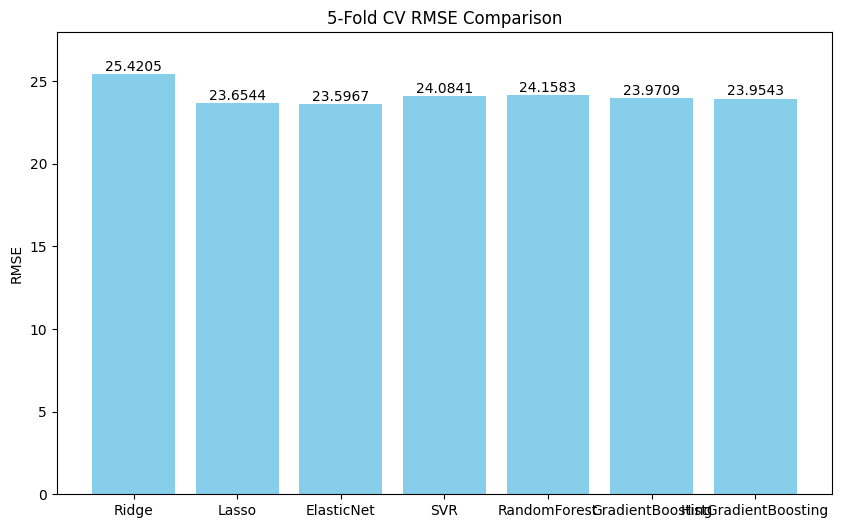

In [9]:
def get_model(name, params):
    if name == "Ridge":
        return make_pipeline(StandardScaler(), Ridge(**params))
    elif name == "Lasso":
        return make_pipeline(StandardScaler(), Lasso(max_iter=10000, **params))
    elif name == "ElasticNet":
        return make_pipeline(StandardScaler(), ElasticNet(max_iter=10000, **params))
    elif name == "SVR":
        return make_pipeline(StandardScaler(), SVR(**params))
    elif name == "RandomForest":
        return RandomForestRegressor(random_state=42, n_jobs=-1, **params)
    elif name == "GradientBoosting":
        return GradientBoostingRegressor(random_state=42, **params)
    elif name == "HistGradientBoosting":
        return HistGradientBoostingRegressor(random_state=42, **params)
    else:
        raise ValueError(f"Unknown model name: {name}")

model_names = []
rmse_scores = []

for name, res in study_results.items():
    model = get_model(name, res['best_params'])
    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_root_mean_squared_error')
    mean_rmse = -scores.mean()
    model_names.append(name)
    rmse_scores.append(mean_rmse)

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, rmse_scores, color='skyblue')
plt.ylabel("RMSE")
plt.title("5-Fold CV RMSE Comparison")

for bar, rmse in zip(bars, rmse_scores):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, f"{rmse:.4f}", ha='center', va='bottom')

plt.ylim(0, max(rmse_scores)*1.1)
plt.show()

In [10]:
print("\n=== Final Training Set RMSE Evaluation ===")
for name, res in study_results.items():
    model = get_model(name, res['best_params'])
    model.fit(X, y)
    preds = model.predict(X)
    mse = mean_squared_error(y, preds) 
    rmse = np.sqrt(mse) 
    print(f"{name:25s} RMSE on train set: {rmse:.4f}")


=== Final Training Set RMSE Evaluation ===
Ridge                     RMSE on train set: 18.9621
Lasso                     RMSE on train set: 22.3037
ElasticNet                RMSE on train set: 22.1790
SVR                       RMSE on train set: 22.5239
RandomForest              RMSE on train set: 13.6115
GradientBoosting          RMSE on train set: 13.0859
HistGradientBoosting      RMSE on train set: 13.9650
